In [1]:
# load the data folder
import numpy as np
import keras.backend as K
from keras.models import load_model


class YOLO:
    def __init__(self, obj_threshold, nms_threshold):
        """Init.

        # Arguments
            obj_threshold: Integer, threshold for object.
            nms_threshold: Integer, threshold for box.
        """
        self._t1 = obj_threshold
        self._t2 = nms_threshold
        self._yolo = load_model('yolo.h5')

    def _process_feats(self, out, anchors, mask):
        """process output features.

        # Arguments
            out: Tensor (N, N, 3, 4 + 1 +80), output feature map of yolo.
            anchors: List, anchors for box.
            mask: List, mask for anchors.

        # Returns
            boxes: ndarray (N, N, 3, 4), x,y,w,h for per box.
            box_confidence: ndarray (N, N, 3, 1), confidence for per box.
            box_class_probs: ndarray (N, N, 3, 80), class probs for per box.
        """
        grid_h, grid_w, num_boxes = map(int, out.shape[1: 4])

        anchors = [anchors[i] for i in mask]
        # Reshape to batch, height, width, num_anchors, box_params.
        anchors_tensor = K.reshape(K.variable(anchors),
                                   [1, 1, len(anchors), 2])
        out = out[0]
        box_xy = K.get_value(K.sigmoid(out[..., :2]))
        box_wh = K.get_value(K.exp(out[..., 2:4]) * anchors_tensor)
        box_confidence = K.get_value(K.sigmoid(out[..., 4]))
        box_confidence = np.expand_dims(box_confidence, axis=-1)
        box_class_probs = K.get_value(K.sigmoid(out[..., 5:]))

        col = np.tile(np.arange(0, grid_w), grid_w).reshape(-1, grid_w)
        row = np.tile(np.arange(0, grid_h).reshape(-1, 1), grid_h)

        col = col.reshape(grid_h, grid_w, 1, 1).repeat(3, axis=-2)
        row = row.reshape(grid_h, grid_w, 1, 1).repeat(3, axis=-2)
        grid = np.concatenate((col, row), axis=-1)

        box_xy += grid
        box_xy /= (grid_w, grid_h)
        box_wh /= (416, 416)
        box_xy -= (box_wh / 2.)
        boxes = np.concatenate((box_xy, box_wh), axis=-1)

        return boxes, box_confidence, box_class_probs

    def _filter_boxes(self, boxes, box_confidences, box_class_probs):
        """Filter boxes with object threshold.

        # Arguments
            boxes: ndarray, boxes of objects.
            box_confidences: ndarray, confidences of objects.
            box_class_probs: ndarray, class_probs of objects.

        # Returns
            boxes: ndarray, filtered boxes.
            classes: ndarray, classes for boxes.
            scores: ndarray, scores for boxes.
        """
        box_scores = box_confidences * box_class_probs
        box_classes = np.argmax(box_scores, axis=-1)
        box_class_scores = np.max(box_scores, axis=-1)
        pos = np.where(box_class_scores >= self._t1)

        boxes = boxes[pos]
        classes = box_classes[pos]
        scores = box_class_scores[pos]

        return boxes, classes, scores

    def _nms_boxes(self, boxes, scores):
        """Suppress non-maximal boxes.

        # Arguments
            boxes: ndarray, boxes of objects.
            scores: ndarray, scores of objects.

        # Returns
            keep: ndarray, index of effective boxes.
        """
        x = boxes[:, 0]
        y = boxes[:, 1]
        w = boxes[:, 2]
        h = boxes[:, 3]

        areas = w * h
        order = scores.argsort()[::-1]

        keep = []
        while order.size > 0:
            i = order[0]
            keep.append(i)

            xx1 = np.maximum(x[i], x[order[1:]])
            yy1 = np.maximum(y[i], y[order[1:]])
            xx2 = np.minimum(x[i] + w[i], x[order[1:]] + w[order[1:]])
            yy2 = np.minimum(y[i] + h[i], y[order[1:]] + h[order[1:]])

            w1 = np.maximum(0.0, xx2 - xx1 + 1)
            h1 = np.maximum(0.0, yy2 - yy1 + 1)
            inter = w1 * h1

            ovr = inter / (areas[i] + areas[order[1:]] - inter)
            inds = np.where(ovr <= self._t2)[0]
            order = order[inds + 1]

        keep = np.array(keep)

        return keep

    def _yolo_out(self, outs, shape):
        """Process output of yolo base net.

        # Argument:
            outs: output of yolo base net.
            shape: shape of original image.

        # Returns:
            boxes: ndarray, boxes of objects.
            classes: ndarray, classes of objects.
            scores: ndarray, scores of objects.
        """
        masks = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
        anchors = [[10, 13], [16, 30], [33, 23], [30, 61], [62, 45],
                   [59, 119], [116, 90], [156, 198], [373, 326]]

        boxes, classes, scores = [], [], []

        for out, mask in zip(outs, masks):
            b, c, s = self._process_feats(out, anchors, mask)
            b, c, s = self._filter_boxes(b, c, s)
            boxes.append(b)
            classes.append(c)
            scores.append(s)

        boxes = np.concatenate(boxes)
        classes = np.concatenate(classes)
        scores = np.concatenate(scores)

        # Scale boxes back to original image shape.
        width, height = shape[1], shape[0]
        image_dims = [width, height, width, height]
        boxes = boxes * image_dims

        nboxes, nclasses, nscores = [], [], []
        for c in set(classes):
            inds = np.where(classes == c)
            b = boxes[inds]
            c = classes[inds]
            s = scores[inds]

            keep = self._nms_boxes(b, s)

            nboxes.append(b[keep])
            nclasses.append(c[keep])
            nscores.append(s[keep])

        if not nclasses and not nscores:
            return None, None, None

        boxes = np.concatenate(nboxes)
        classes = np.concatenate(nclasses)
        scores = np.concatenate(nscores)

        return boxes, classes, scores

    def predict(self, image, shape):
        """Detect the objects with yolo.

        # Arguments
            image: ndarray, processed input image.
            shape: shape of original image.

        # Returns
            boxes: ndarray, boxes of objects.
            classes: ndarray, classes of objects.
            scores: ndarray, scores of objects.
        """

        outs = self._yolo.predict(image)
        boxes, classes, scores = self._yolo_out(outs, shape)

        return boxes, classes, scores


In [2]:
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def process_image(img):
    """Resize, reduce and expand image.

    # Argument:
        img: original image.

    # Returns
        image: ndarray(64, 64, 3), processed image.
    """
    image = cv2.resize(img, (416, 416),
                       interpolation=cv2.INTER_CUBIC)
    image = np.array(image, dtype='float32')
    image /= 255.
    image = np.expand_dims(image, axis=0)

    return image

In [4]:
def get_classes(file):
    """Get classes name.

    # Argument:
        file: classes name for database.

    # Returns
        class_names: List, classes name.

    """
    with open(file) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]

    return class_names

In [5]:
def draw(image, boxes, scores, classes, all_classes):
    """Draw the boxes on the image.

    # Argument:
        image: original image.
        boxes: ndarray, boxes of objects.
        classes: ndarray, classes of objects.
        scores: ndarray, scores of objects.
        all_classes: all classes name.
    """
    for box, score, cl in zip(boxes, scores, classes):
        x, y, w, h = box

        top = max(0, np.floor(x + 0.5).astype(int))
        left = max(0, np.floor(y + 0.5).astype(int))
        right = min(image.shape[1], np.floor(x + w + 0.5).astype(int))
        bottom = min(image.shape[0], np.floor(y + h + 0.5).astype(int))

        cv2.rectangle(image, (top, left), (right, bottom), (255, 0, 0), 2)
        cv2.putText(image, '{0} {1:.2f}'.format(all_classes[cl], score),
                    (top, left - 6),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 0, 255), 1,
                    cv2.LINE_AA)

        print('class: {0}, score: {1:.2f}'.format(all_classes[cl], score))
        print('box coordinate x,y,w,h: {0}'.format(box))

    print()

In [6]:
def detect_image(image, yolo, all_classes):
    """Use yolo v3 to detect images.

    # Argument:
        image: original image.
        yolo: YOLO, yolo model.
        all_classes: all classes name.

    # Returns:
        image: processed image.
    """
    pimage = process_image(image)

    start = time.time()
    boxes, classes, scores = yolo.predict(pimage, image.shape)
    end = time.time()

    print('time: {0:.2f}s'.format(end - start))

    if boxes is not None:
        draw(image, boxes, scores, classes, all_classes)

    return image

In [7]:
def detect_video(video, yolo, all_classes):
    """Use yolo v3 to detect video.

    # Argument:
        video: video file.
        yolo: YOLO, yolo model.
        all_classes: all classes name.
    """
    video_path = os.path.join("videos", "test", video)
    camera = cv2.VideoCapture(video_path)
    cv2.namedWindow("detection", cv2.WINDOW_AUTOSIZE)

    # Prepare for saving the detected video
    sz = (int(camera.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(camera.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    fourcc = cv2.VideoWriter_fourcc(*'mpeg')

    
    vout = cv2.VideoWriter()
    vout.open(os.path.join("videos", "res", video), fourcc, 20, sz, True)

    while True:
        res, frame = camera.read()

        if not res:
            break

        image = detect_image(frame, yolo, all_classes)
        cv2.imshow("detection", image)

        # Save the video frame by frame
        vout.write(image)

        if cv2.waitKey(110) & 0xff == 27:
                break

    vout.release()
    camera.release()
    

In [13]:
## coco  data sete has over 1.5 million object instances with 80 diffrent object categories 
#  we would be using transfer learning that is pre trained model on this coco data data set
yolo = YOLO(0.6, 0.5)
file = 'coco_classes.txt'
all_classes = get_classes(file)

In [14]:
all_classes

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [15]:
len(all_classes)

80

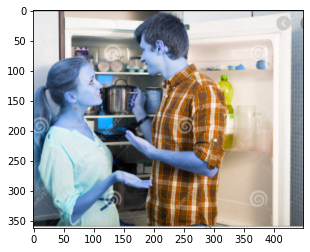

In [16]:
image = cv2.imread(r"F:\study\data science\opencv\personfridge.PNG" )
plt.imshow(image)

### Detecting Images

In [17]:

image = detect_image(image, yolo, all_classes)
cv2.imwrite(  "image_res1.PNG", image)

time: 7.00s
class: person, score: 1.00
box coordinate x,y,w,h: [150.61255395   3.11925107 175.5167976  352.67065275]
class: person, score: 0.90
box coordinate x,y,w,h: [  1.94694847  74.03823119 182.00814575 284.28005159]
class: refrigerator, score: 0.97
box coordinate x,y,w,h: [153.8078025    8.13875651 270.68641484 349.99186134]



True

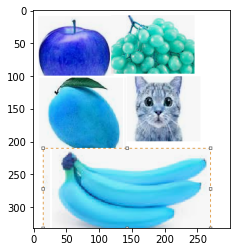

In [18]:
#eample 2 of image 

image1 = cv2.imread(r"F:\study\data science\opencv\ImageForYolo.PNG")

plt.imshow(image1)

In [19]:

image1 = detect_image(image1, yolo, all_classes)
cv2.imwrite(  "image2.PNG", image1)

time: 4.02s
class: banana, score: 0.69
box coordinate x,y,w,h: [ 44.92726028 210.54887128 218.61060262 116.03211033]
class: cat, score: 0.99
box coordinate x,y,w,h: [151.99205875 102.22509933  79.13872898 105.32634151]



True

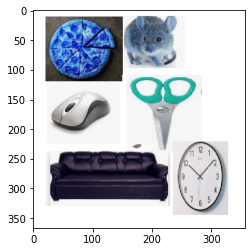

In [20]:
### example 3



image3 = cv2.imread(r"F:\study\data science\opencv\ImageForYolo1.PNG")

plt.imshow(image3)

In [21]:
image3 = detect_image(image3, yolo, all_classes)
cv2.imwrite(  "image3.PNG", image3)

time: 5.49s
class: mouse, score: 0.95
box coordinate x,y,w,h: [ 30.91386864 135.14594987  94.60529125  65.24476321]
class: clock, score: 0.99
box coordinate x,y,w,h: [243.75551307 222.58378273  80.91118336 112.87209073]
class: clock, score: 0.71
box coordinate x,y,w,h: [ 25.89850834  16.53940758 117.33581138 100.14039311]
class: cat, score: 0.89
box coordinate x,y,w,h: [157.4245522    6.70105985  88.50715333  90.93006295]



True

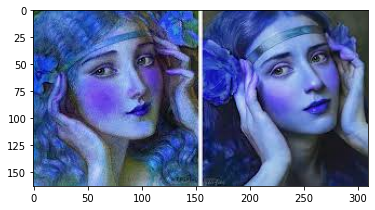

In [23]:
#example4

image4 = cv2.imread(r"F:\study\data science\opencv\b1.jpg")
plt.imshow(image4)

In [24]:
image4 = detect_image(image4, yolo, all_classes)
cv2.imwrite(  "image4.PNG", image4)

time: 4.17s


True

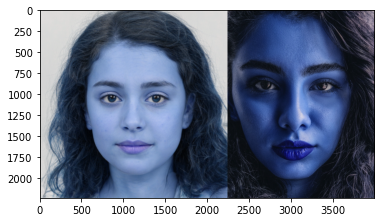

In [28]:
#example4

image5 = cv2.imread(r"F:\study\data science\opencv\frontface.png")
plt.imshow(image5)

In [29]:
image5 = detect_image(image5, yolo, all_classes)
cv2.imwrite(  "image5.PNG", image5)

time: 6.11s
class: person, score: 1.00
box coordinate x,y,w,h: [ -35.76529026   65.47259107 2277.70256996 2161.18957943]
class: person, score: 0.99
box coordinate x,y,w,h: [2111.97757721   54.52302513 1846.29321098 2087.65865391]



True